In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 

# reads in all the words
words = open("names.txt", 'r').read().splitlines()

# building encoder
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

# set parameters
n_hidden = 100
n_embd = 2
numb_tests = 1000
block_size = 3 # context, number of characters taken in to predict the next
vocab_size = len(itos)


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g) # embed table, 27 rows for 27 characters, crammed into a two dimensional space(each character has a 2d embedding)
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g) # first number corresponds to the number of embeddings in emb, which for each data point is 3, 2 = 6. Second num is number of neurons
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.01 #output is number of characters, made smaller to minimize logits on first iteration
b2 = torch.randn(vocab_size, generator=g) * 0 # makes biases all 0 and equal at initialization
parameters = [C, b1, W2, b2, W1]
for p in parameters:
    p.requires_grad = True

In [12]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size # padding with [0] = '.'
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix) 
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
 # training split, dev/validation split, test split
 # 80%, 10%, 10%
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [13]:
emb = C[Xtr]
embcat = emb.view(emb.shape[0], -1) # concatenates the vectors
hpreact = embcat @ W1 + b1 # hidden layer pre-activation, note that since the equation of self_grad of a neuron is proportional to (1-hpreact**2), this can only ever decrease, and
                           # approaches zero whenever t approaches abs(1) 
h = torch.tanh(hpreact) # activation of hidden states/hidden layer
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr) 

In [15]:
lossi = []
stepi = []
batch_size = 32
# backward pass
for i in range(numb_tests):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, )) # list of 32 integers that index into the data, e.g their range is between 0 and number of data inputs,
    

    # forward pass
    emb = C[Xtr[ix]] # shape = (X.shape[0], block_size, n_hidden)
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix]) # loss function
    for p in parameters:
        p.grad = None

    loss.backward() # updates gradients for each neuron

    # update
    lr = 0.1 if i < (numb_tests/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad # adjust data according to gradient
    lossi.append(loss.item())
    stepi.append(i)


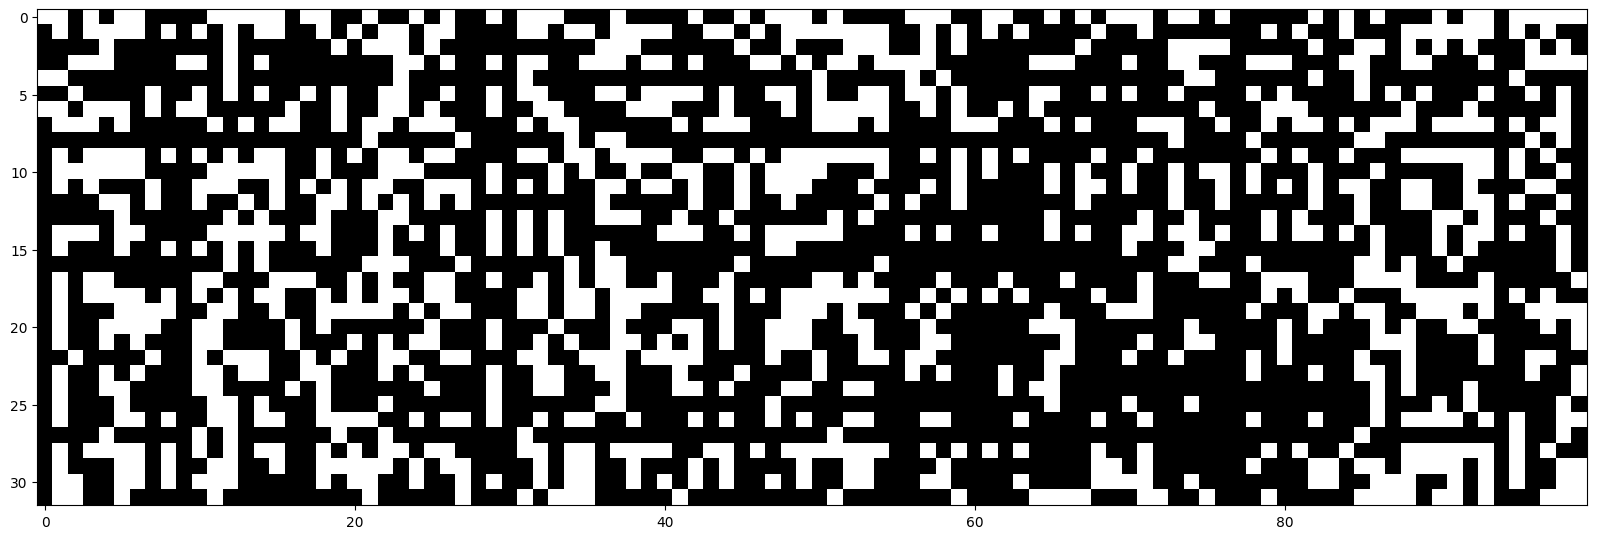

In [16]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')